## Общее описание
Представьте, что вы работаете в крупном дейтинговом приложении.
Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.
Проверьте:
* Был ли эксперимент успешен в целом.
* Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

### Описание данных
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

– информация о пользователях:
* uid – идентификатор пользователя
* age – возраст
* attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки/просмотры*1000)
* coins – число монеток (внутренняя валюта)
* country – страна  
* visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
* gender – пол
* age_filter_start  – фильтр поиска, мин. значение 
* age_filter_end  – фильтр поиска, макс. значение 
* views_count – число полученных оценок 
* was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
* is_premium –  является ли премиум
* total_revenue – нормированная выручка
 
– информация о платежах пользователей:
* uid – идентификатор пользователя
* country – страна
* joined_at – дата и время регистрации
* paid_at – дата и время покупки
* revenue – нормированная выручка
* payment_id – идентификатор платежа
* from_page – откуда пользователь перешел на страницу оплаты
* product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной,
coins  – подписка за внутреннюю валюту, other_type – другое)


### Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
users_test = pd.read_csv('Проект_3_users_test.csv', sep=';')
users_control_1 = pd.read_csv('Проект_3_users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('Проект_3_users_control_2.csv', sep=';')

In [3]:
transactions_test = pd.read_csv('Проект_3_transactions_test.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_control_1 = pd.read_csv('Проект_3_transactions_control_1.csv', sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_control_2 = pd.read_csv('Проект_3_transactions_control_2.csv', sep=';', parse_dates=['joined_at', 'paid_at'])

### EDA

In [4]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [5]:
users_test.shape

(4308, 13)

In [6]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

**Колонки was_premium и is_premium во всех файлах предполагают тип данных bool, т.е. либо 0, либо 1. Т.к. единицы проставлены, то остальные NaN значения заменены на ноль.**

In [7]:
users_test['was_premium'] = users_test.was_premium.fillna(0)
users_test['is_premium'] = users_test.is_premium.fillna(0)

In [8]:
users_test.gender.value_counts()

1    4106
0     202
Name: gender, dtype: int64

In [9]:
users_test.describe(include='object')

,country,visit_days
count,4308,2978
unique,51,891
top,United States of America,1
freq,1450,525


In [10]:
users_test.age.describe()

count    4308.000000
mean       31.889276
std        10.245287
min        16.000000
25%        25.000000
50%        30.000000
75%        38.000000
max        99.000000
Name: age, dtype: float64

In [11]:
users_control_1.shape

(4340, 13)

In [12]:
users_control_1['was_premium'] = users_control_1.was_premium.fillna(0)
users_control_1['is_premium'] = users_control_1.is_premium.fillna(0)

In [13]:
users_control_1.describe(include='object')

,country,visit_days
count,4340,3016
unique,40,880
top,United States of America,1
freq,1471,592


In [14]:
users_control_1.age.describe()

count    4340.000000
mean       32.095392
std        10.257466
min        16.000000
25%        24.000000
50%        30.000000
75%        38.000000
max        99.000000
Name: age, dtype: float64

In [15]:
users_control_1.gender.value_counts()

1    4158
0     182
Name: gender, dtype: int64

In [16]:
users_control_2.shape

(4264, 13)

In [17]:
users_control_2['was_premium'] = users_control_2.was_premium.fillna(0)
users_control_2['is_premium'] = users_control_2.is_premium.fillna(0)

In [18]:
users_control_2.describe(include='object')

,country,visit_days
count,4264,2900
unique,45,837
top,United States of America,1
freq,1486,587


In [19]:
users_control_2.age.describe()

count    4264.000000
mean       32.046201
std        10.170721
min        16.000000
25%        25.000000
50%        30.000000
75%        38.000000
max        99.000000
Name: age, dtype: float64

In [20]:
users_control_2.gender.value_counts()

1    4069
0     195
Name: gender, dtype: int64

In [21]:
transactions_test.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [22]:
transactions_test.describe(include='object')

,country,from_page,product_type
count,273,273,273
unique,17,22,4
top,United States of America,empty_likes,coins
freq,94,72,106


In [23]:
transactions_test.product_type.value_counts(normalize=True)

coins               0.388278
premium_no_trial    0.278388
trial_premium       0.227106
other_type          0.106227
Name: product_type, dtype: float64

In [24]:
transactions_control_1.product_type.value_counts(normalize=True)

coins               0.395225
premium_no_trial    0.281167
trial_premium       0.177719
other_type          0.145889
Name: product_type, dtype: float64

In [25]:
transactions_control_2.product_type.value_counts(normalize=True)

coins               0.378049
premium_no_trial    0.326220
trial_premium       0.161585
other_type          0.134146
Name: product_type, dtype: float64

In [26]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [27]:
transactions_control_1 = transactions_control_1.dropna()

In [28]:
transactions_control_1.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [29]:
transactions_test['uid'] = transactions_test.uid.astype(int)
transactions_control_1['uid'] = transactions_control_1.uid.astype(int)
transactions_control_2['uid'] = transactions_control_2.uid.astype(int)

In [30]:
transactions_test.joined_at.min()

Timestamp('2017-01-11 03:07:00')

In [31]:
transactions_test.joined_at.max()

Timestamp('2017-10-31 23:40:00')

In [32]:
transactions_control_1.joined_at.min()

Timestamp('2015-01-19 11:49:00')

In [33]:
transactions_control_1.joined_at.max()

Timestamp('2017-10-31 22:17:00')

In [34]:
transactions_control_2.joined_at.min()

Timestamp('2017-01-11 08:36:00')

In [35]:
transactions_control_2.joined_at.max()

Timestamp('2017-10-31 17:43:00')

In [36]:
transactions_test.groupby('uid').agg({'revenue':'sum'}).sort_values('revenue', ascending=False)

,revenue
uid,
891178380,129870
892038759,123565
892236423,95823
891346269,75647
892150854,61789
...,...
891347046,1261
892333656,897
891175326,897


In [37]:
users_test.query('total_revenue > 0').count()

uid                 146
age                 146
attraction_coeff    146
coins                47
country             146
visit_days          127
gender              146
age_filter_start    146
age_filter_end      146
views_count         146
was_premium         146
is_premium          146
total_revenue       146
dtype: int64

In [38]:
transactions_control_1.groupby('uid').agg({'revenue':'sum'}).sort_values('revenue', ascending=False)

,revenue
uid,
892333905,486330.0
892216461,64298.0
891383310,63037.0
892366260,63024.0
892421277,60333.0
...,...
891792453,1313.0
891135642,962.0
960936960,806.0


In [39]:
transactions_control_1.query('joined_at < "2017-01-11"')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type
101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type
224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type


In [40]:
users_control_1.query('total_revenue > 0').count()

uid                 192
age                 192
attraction_coeff    192
coins                60
country             192
visit_days          175
gender              192
age_filter_start    192
age_filter_end      192
views_count         192
was_premium         192
is_premium          192
total_revenue       192
dtype: int64

In [41]:
transactions_control_2.groupby('uid').agg({'revenue':'sum'}).sort_values('revenue', ascending=False)

,revenue
uid,
891778551,81796
892307238,75647
891637005,34125
892128138,30849
891664350,28119
...,...
891333651,1456
891878595,1261
891260820,897


In [42]:
users_control_2.query('total_revenue > 0').count()

uid                 187
age                 187
attraction_coeff    187
coins                58
country             187
visit_days          169
gender              187
age_filter_start    187
age_filter_end      187
views_count         187
was_premium         187
is_premium          187
total_revenue       187
dtype: int64

In [43]:
transactions_control_1 = transactions_control_1.loc[transactions_control_1['uid'] != 960936960]
users_control_1 = users_control_1.loc[users_control_1['uid'] != 960936960]

In [44]:
transactions_control_1.joined_at.min()

Timestamp('2017-01-11 01:06:00')

In [45]:
transactions_control_1.nunique()

uid             192
country          17
joined_at       192
paid_at         332
revenue         124
payment_id        7
from_page        22
product_type      4
dtype: int64

In [46]:
users_control_1.query('total_revenue > 0').count()

uid                 191
age                 191
attraction_coeff    191
coins                59
country             191
visit_days          174
gender              191
age_filter_start    191
age_filter_end      191
views_count         191
was_premium         191
is_premium          191
total_revenue       191
dtype: int64

In [47]:
transactions_control_1 = transactions_control_1.loc[transactions_control_1['uid'] != 892355163]

В целом можно сделать вывод, что участники A/B-теста равномерно распределены, и группы пользователей однородны по количеству и составу. Но в контрольную группу 1 попал пользователь, который зарегистрировался задолго до начала эксперимента, что не соответствует требованиям к его проведению, т.к. тест проводился для новых пользователей. Поэтому пользователь c uid 960936960 исключен из таблиц. После этого нашелся еще один пользователь из таблицы транзакций, который по какой-то причине не попал в таблицу пользователей, он так же исключен. 

### Гипотезы

#### 1. Метрики эксперимента

Компания работает по модели freemium. 
Т.к. в рамках эксперимента была изменена стоимость премиум подписки, то, скорее всего, компания хотела повлиять на сумму выручки и прибыли, поэтому следует обратить внимание на метрики ARPU, ARPPU и средний чек. Так же интересно проанализировать как изменилось количество платящих пользователей в абсолютном выражении и paying share. Вспомогательными метриками в таком эксперименте могут быть продления премиум подписки и конверсия в премиум пользователя.

Как видно по расчетам, изменение стоимости подписки привело к увеличению среднего чека и ARPPU, но при этом доля платящих пользователей и ARPU уменьшились. Не смотря на то, что метрику ARPPU можно трактовать как реакцию пользователей на цены, установленные в проекте, я думаю, что ARPU  в данном случае важнее и показательнее. Во-первых потому, что премиум подписка не является самым популярным видом покупки среди пользователей данного приложения, большинство предпочитают купить коины. Во-вторых, именно ARPU в конечном итоге влияет на LTV.

In [48]:
B_ARPU = round(users_test.total_revenue.sum() / users_test.shape[0], 2)
A1_ARPU = round(users_control_1.total_revenue.sum() / users_control_1.shape[0], 2)
A2_ARPU = round(users_control_2.total_revenue.sum() / users_control_2.shape[0], 2)
print(f'''Показатель ARPU в тестовой группе равен {B_ARPU}, в первой контрольной группе - {A1_ARPU},
во второй контрольной группе - {A2_ARPU}''')

Показатель ARPU в тестовой группе равен 534.08, в первой контрольной группе - 594.89,
во второй контрольной группе - 450.38


In [49]:
B_AOV = round(transactions_test.revenue.sum() / transactions_test.shape[0], 2)
A1_AOV = round(transactions_control_1.revenue.sum() / transactions_control_1.shape[0], 2)
A2_AOV = round(transactions_control_2.revenue.sum() / transactions_control_2.shape[0], 2)
print(f'''Средний чек в тестовой группе равен {B_AOV}, в первой контрольной группе - {A1_AOV},
во второй контрольной группе - {A2_AOV}''')

Средний чек в тестовой группе равен 8589.38, в первой контрольной группе - 6920.22,
во второй контрольной группе - 5854.99


In [50]:
B_ARPPU = round(transactions_test.revenue.sum() / transactions_test.uid.nunique(), 2)
A1_ARPPU = round(transactions_control_1.revenue.sum() / transactions_control_1.uid.nunique(), 2)
A2_ARPPU = round(transactions_control_2.revenue.sum() / transactions_control_2.uid.nunique(), 2)
print(f'''Показатель ARPPU в тестовой группе равен {B_ARPPU}, в первой контрольной группе - {A1_ARPPU},
во второй контрольной группе - {A2_ARPPU}''')

Показатель ARPPU в тестовой группе равен 16060.97, в первой контрольной группе - 13514.35,
во второй контрольной группе - 10269.72


In [51]:
B_ps = round(transactions_test.uid.nunique() / users_test.uid.nunique() * 100, 2)
A1_ps = round(transactions_control_1.uid.nunique() / users_control_1.uid.nunique() * 100, 2)
A2_ps = round(transactions_control_2.uid.nunique() / users_control_2.uid.nunique() * 100, 2)
print(f'''Доля платящих пользователей в тестовой группе составила {B_ps}, в первой контрольной группе - {A1_ps},
во второй контрольной группе - {A2_ps}''')

Доля платящих пользователей в тестовой группе составила 3.39, в первой контрольной группе - 4.4,
во второй контрольной группе - 4.39


#### 2. Проверка значимости результатов теста

Т.к. у нас есть результаты по тестовой и двум контрольным группам, то это означает, что был проведен А/А/Б-тест. Судя по всему, вторая контрольная группа служила страховкой на случай, если другие команды в компании будут проводить сплит-тесты с теми же целевыми метриками. В данном случае нулевая гипотеза будет о равенстве средних (т.е. ARPU), и мы хотим принимать нулевую гипотезу в паре А1/А2 и отвергать в паре А1+А2/Б.

In [52]:
A1 = users_control_1.total_revenue
A2 = users_control_2.total_revenue

Проверим равенство дисперсий в группах критерием Левена. Н0: дисперсии в группах А1 и А2 равны, Н1: дисперсии в группах различаются.

In [53]:
ss.levene(A1, A2)

LeveneResult(statistic=1.2392124768547264, pvalue=0.2656539923222671)

Так как p-value < 0.05, то мы отклоняем нулевую гипотезу о гомогенности дисперсий выборок и используем далее поправку Уэлша.

  0%|          | 0/1000 [00:00<?, ?it/s]

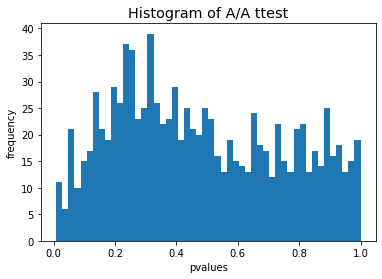

0.02

In [54]:
#FPR - false positive rate
# уровень альфа установлен 0.05
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = A1.sample(n_s, replace = False).values
    s2 = A2.sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of A/A ttest")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations
# FPR < альфа и сплит-система работает корректно!

In [55]:
users_control = pd.concat([users_control_1, users_control_2], axis = 0)

In [56]:
A = users_control.total_revenue
B = users_test.total_revenue

**Тестируем нормальность распределения средних с помощью бутстрапа (при уровне альфа 0.05):**

In [57]:
# контрольная группа
boot_it = 5000
A_boot_data = []
boot_conf_level = 0.95
for i in range(boot_it):
    samples = A.sample(len(A), replace = True)
    A_boot_data.append(np.mean(samples))

In [58]:
# Найдем доверительный интервал для контрольной группы
left_ci = (1 - boot_conf_level)/2
right_ci = 1 - (1 - boot_conf_level) / 2
ci = pd.Series(A_boot_data).quantile([left_ci, right_ci])

print(ci)

0.025    419.612135
0.975    669.007910
dtype: float64


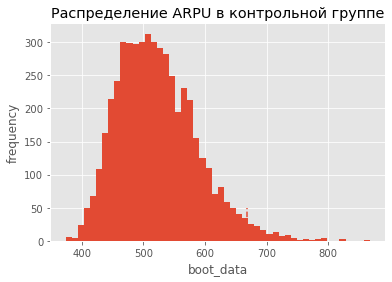

In [59]:
plt.hist(pd.Series(A_boot_data), bins = 50)
plt.style.use('ggplot')
plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data')
plt.ylabel('frequency')
plt.title("Распределение ARPU в контрольной группе")
plt.show()

In [60]:
# тестовая группа
boot_it = 5000
B_boot_data = []
boot_conf_level = 0.95
for i in range(boot_it):
    samples = B.sample(len(B), replace = True)
    B_boot_data.append(np.mean(samples))

In [61]:
# Найдем доверительный интервал для тестовой группы
left_ci = (1 - boot_conf_level)/2
right_ci = 1 - (1 - boot_conf_level) / 2
ci = pd.Series(B_boot_data).quantile([left_ci, right_ci])

print(ci)

0.025    411.170265
0.975    667.973149
dtype: float64


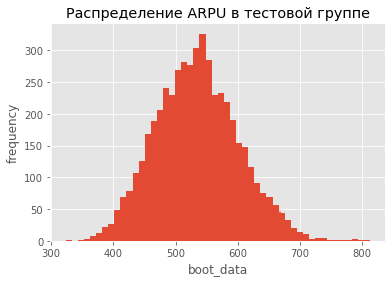

In [62]:
plt.hist(pd.Series(B_boot_data), bins = 50)
plt.style.use('ggplot')
plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
plt.xlabel('boot_data')
plt.ylabel('frequency')
plt.title("Распределение ARPU в тестовой группе")
plt.show()

**Тестируем равенство дисперсий в группах критерием Левена. Н0: дисперсии в группах А и B равны, Н1: дисперсии в группах различаются.**

In [63]:
ss.levene(A, B)

LeveneResult(statistic=0.010992182969404754, pvalue=0.9165015322539012)

Так как p-value > 0.05, то мы не имеем оснований отклонить нулевую гипотезу о гомогенности дисперсий.

Т.к. дисперсии равны и распределение стастики в обеих группах близко к нормальному, то можно использовать т-тест для проверки гипотезы о равенстве средних в двух группах.

In [64]:
ss.ttest_ind(A, B, equal_var=True)

Ttest_indResult(statistic=-0.10484361196279321, pvalue=0.9165015322528947)

Либо можем использовать бутстрап для проверки гипотезы о значимом изменении ARPU:

  0%|          | 0/5000 [00:00<?, ?it/s]

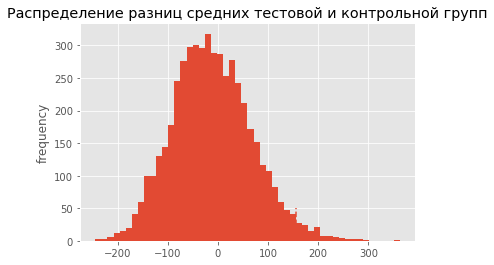

доверительный интервал:                 0
0.025 -153.127322
0.975  154.840532, p_value: 0.887268433632969


In [65]:
boot_it = 5000
statistic = np.mean
bootstrap_conf_level = 0.95
boot_len = max([len(A), len(B)])
AB_test_boot_data = []
    
for i in tqdm(range(boot_it)):
    samples_1 = A.sample(boot_len, replace = True).values
    samples_2 = B.sample(boot_len, replace = True).values
    AB_test_boot_data.append(statistic(samples_1-samples_2))
        
pd_AB_test = pd.DataFrame(AB_test_boot_data)
        
left_quant = (1 - bootstrap_conf_level)/2
right_quant = 1 - (1 - bootstrap_conf_level) / 2
ci = pd_AB_test.quantile([left_quant, right_quant])
        
p_1 = ss.norm.cdf(x = 0, loc = np.mean(AB_test_boot_data), scale = np.std(AB_test_boot_data))
p_2 = ss.norm.cdf(x = 0, loc = -np.mean(AB_test_boot_data), scale = np.std(AB_test_boot_data))
p_value = min(p_1, p_2) * 2
        
# Визуализация
plt.hist(pd_AB_test[0], bins = 50) 
plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
plt.style.use('ggplot')
plt.ylabel('frequency')
plt.title("Распределение разниц средних тестовой и контрольной групп")
plt.show()

print(f'доверительный интервал: {ci}, p_value: {p_value}')

**Т.к. доверительный интервал включает ноль, то мы принимаем нулевую гипотезу о равенстве средних. В результате эксперимента не получено значимое изменение ARPU в тестовой группе при изменении стоимости премиум-подписки. Попробуем проанализировать сегменты премиум-пользователей:** 

In [66]:
transactions_control = pd.concat([transactions_control_1, transactions_control_2], axis=0)

In [67]:
# популярность платных продуктов в тестовой группе по странам.
pd.pivot_table(transactions_test, values = 'revenue', index = 'country', columns = 'product_type', aggfunc = 'mean')

product_type,coins,other_type,premium_no_trial,trial_premium
country,,,,
Argentina,31525.000000,30264.000000,9882.600000,13767.000000
Australia,NaN,NaN,12597.000000,NaN
Belgium,5863.000000,NaN,12597.000000,12787.666667
Canada,3214.250000,3549.000000,6119.750000,11290.500000
Chile,3475.333333,NaN,8181.333333,NaN
France,3510.000000,16009.500000,6677.666667,15660.666667
Germany,16562.000000,NaN,5167.500000,13159.250000
Israel,2522.000000,2736.500000,12597.000000,14369.333333
Italy,4264.000000,1469.000000,7400.250000,12909.000000


In [68]:
# популярность платных продуктов в контрольной группе по странам.
pd.pivot_table(transactions_control, values = 'revenue', index = 'country', columns = 'product_type', aggfunc = 'mean')

product_type,coins,other_type,premium_no_trial,trial_premium
country,,,,
Argentina,3474.120000,NaN,6724.250000,10907.000000
Australia,1313.000000,NaN,4342.000000,13305.500000
Austria,4056.000000,NaN,4056.000000,NaN
Belgium,3045.250000,2314.000000,5956.166667,15087.428571
Canada,3791.125000,3783.000000,4877.600000,10681.666667
Chile,4618.250000,3484.000000,5825.300000,11375.000000
France,2346.782609,2668.714286,5367.142857,13459.727273
Germany,6989.666667,2327.000000,5816.571429,14534.000000
India,NaN,NaN,4810.000000,NaN


Посмотрим на распределение пользователей премиум-подписки по возрастным группам в тестовой группе.

In [69]:
premium_test = transactions_test.query('product_type == "premium_no_trial"')\
                 .groupby('uid', as_index = False)\
                 .agg({'payment_id':'count'})\
                 .rename(columns = {'payment_id':'payments_number'})

In [70]:
premium_users_test = users_test.merge(premium_test, on = 'uid')

In [71]:
premium_users_test.age.describe()

count    67.000000
mean     32.611940
std      12.060398
min      17.000000
25%      24.000000
50%      32.000000
75%      37.500000
max      99.000000
Name: age, dtype: float64

In [72]:
premium_users_test['age_group'] = pd.cut(premium_users_test.age, bins=[0, 23, 31, 38, 99], labels = ['17-23', '24-31', '32-38', '39-99'])

In [73]:
premium_users_test = premium_users_test[['uid', 'age_group', 'country', 'gender', 'total_revenue', 'payments_number']]
premium_users_test

,uid,age_group,country,gender,total_revenue,payments_number
0,891152790,24-31,Spain,1,12597,1
1,891589239,17-23,Italy,1,37817,1
2,891806436,32-38,Italy,1,12597,1
3,891882681,32-38,Belgium,1,20410,1
4,892211106,32-38,France,1,4537,1
...,...,...,...,...,...,...
62,891312873,17-23,Italy,1,11778,1
63,891071157,17-23,United States of America,1,9100,1
64,891718167,24-31,Chile,1,8164,1
65,891969984,39-99,Argentina,1,5330,1


In [74]:
premium_users_test.query('payments_number > 1')

,uid,age_group,country,gender,total_revenue,payments_number
8,892097937,17-23,Chile,1,28535,3
33,892339626,32-38,United States of America,1,17758,3
40,892065108,39-99,France,1,47242,3
44,891725043,24-31,United Arab Emirates,1,18434,2
52,892261437,32-38,Italy,1,3835,2
60,891861048,32-38,Canada,1,21359,2


In [75]:
pd.pivot_table(premium_users_test, index = 'country', columns = 'age_group', values = 'total_revenue', aggfunc = 'mean')

age_group,17-23,24-31,32-38,39-99
country,,,,
Argentina,NaN,NaN,44122.0,8073.0
Australia,NaN,12597.0,NaN,NaN
Belgium,NaN,NaN,20410.0,NaN
Canada,NaN,4706.0,21359.0,12597.0
Chile,28535.000000,8216.0,24973.0,NaN
France,NaN,7930.0,18024.5,47242.0
Germany,NaN,NaN,6279.0,4056.0
Israel,NaN,21645.0,NaN,16380.0
Italy,20730.666667,NaN,11934.0,1898.0


Аналогично посмотрим на распределение пользователей премиум-подписки по возрастным группам в контрольной группе.

In [76]:
premium_control = transactions_control.query('product_type == "premium_no_trial"')\
                 .groupby('uid', as_index = False)\
                 .agg({'payment_id':'count'})\
                 .rename(columns = {'payment_id':'payments_number'})
premium_users_control = users_control.merge(premium_control, on = 'uid')

In [82]:
premium_users_control.query('payments_number > 1')

,uid,age_group,country,gender,total_revenue,payments_number
3,891264903,17-23,United States of America,1,7761,2
21,892101909,24-31,France,1,14508,2
28,891822480,24-31,Italy,1,17810,2
35,892366260,24-31,United Kingdom (Great Britain),1,63024,2
39,892393119,24-31,Italy,1,3614,2
56,892290105,17-23,United States of America,1,12090,2
88,891216033,17-23,United States of America,1,12584,2
105,891219540,24-31,Australia,1,9438,2
118,892139829,24-31,United Kingdom (Great Britain),1,22243,3
146,891637005,39-99,Spain,1,34125,2


In [77]:
premium_users_control['age_group'] = pd.cut(premium_users_control.age, bins=[0, 23, 31, 38, 99], labels = ['17-23', '24-31', '32-38', '39-99'])

In [78]:
premium_users_control = premium_users_control[['uid', 'age_group', 'country', 'gender', 'total_revenue', 'payments_number']]
pd.pivot_table(premium_users_control, index = 'country', columns = 'age_group', values = 'total_revenue', aggfunc = 'mean')

age_group,17-23,24-31,32-38,39-99
country,,,,
Argentina,9986.600000,14511.250000,7553.000000,9613.500000
Australia,NaN,9438.000000,3588.000000,NaN
Austria,NaN,NaN,12168.000000,NaN
Belgium,8450.000000,6272.500000,NaN,5297.500000
Canada,NaN,8710.000000,4706.000000,NaN
Chile,11966.500000,8037.250000,13708.500000,11336.000000
France,9656.833333,6308.900000,4637.750000,NaN
Germany,3601.000000,5889.000000,14113.666667,6292.000000
India,NaN,4914.000000,NaN,4706.000000


### Итоги

В целом эксперимент по изменению стоимости премиум-подписки не был успешен. Возможно были допущены ошибки при планировании проекта, возможно выборки не репрезентативные. Среди пользователей данного приложения как в тестовой группе, так и в контрольной гораздо популярнее внутренняя валюта, чем премиум-подписка. Однако есть и страны, где это не так, например ОАЭ, Великобритания, Испания. Возможно для этого сегмента имеет смысл изменить стоимость подписки.